In [44]:
import copy

import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation

# CC

In [42]:
#  customized clustering procedure
def cc_procedure(J,R,D):
    # n is number of realocation moves J={1, ..., n}
    # m is number of realocators R={1, ..., m}
    n=len(J)
    m=len(R)

    #initialize a new Trip
    new_trip=Trip([],[],0)

    p=np.floor(n/m)/(np.floor(n/m)+1)
    n_hat=0
    # controllare
    if np.random.uniform(0,1)<=p:
        n_hat=np.random.randint(np.ceil((m+1)/2),m)
    else:
        n_hat=np.random.randint(1,np.ceil((m+1)/2)) #TODO sistemare che metta il secondo incluso

    j=J[np.random.randint(0,len(J))] # len(J) = |J|
    # update
    new_trip.J.append(j) #J'={j} # TODO sistemare si può mettere un metodo dentro Trip
    J.remove(j) # J=J\{j}   P= (u_j^c,v_j^c)
    
    while len(new_trip.J)<n_hat and len(J)!=0:
        p=[]
        for j in J:
            p_j=0.0
            for q in J:
                distance_j=new_trip.distance_from_cluster_center(j)
                distance_q=new_trip.distance_from_cluster_center(q)
                p_j+=distance_j/distance_q if distance_q!=0 else 0
            p.append(p_j**-1 if p_j!=0 else 0.0)
        j=np.random.choice(J, 1, p)[0] # sample from J
        new_trip.J.append(j) #J'={j} # TODO sistemare si può mettere un metodo dentro Trip
        J.remove(j) # J=J\{j}

    l=1
    pi=[]

    # line 7
    probability=[]
    for selected_pi in D:
        p_pi=0.0
        for q in D:
            distance_pi=new_trip.distance_from_cluster_center(selected_pi)
            sum_distance_dropoff=new_trip.distance_from_cluster_center(q)
            p_pi+=distance_pi/sum_distance_dropoff if sum_distance_dropoff!=0 else 0
        probability.append(p_pi**-1 if p_pi!=0 else 0.0)

    pi_l=np.random.choice(D, 1, probability)[0]
    new_trip.pi.append(pi_l) # pi={pi_l} #TODO  sistemare con un metodo
    D.remove(pi_l) # D=D\{pi_l}

    #calculate total duration C of taxi trip pi according to relocation J'
    C=new_trip.duration()

    while len(D)!=0:
        #determine drop-off point q in D which decreases C most
        if(q != None):
            l=l+1
            pi_l=q
            D.remove(q)
        else:
            D=[]

# SA


In [39]:
# FIX IT
# TODO error when n=10, m=1 because n_realocation_moves becomes 0 so all trips have 0 reallocation moves except the last one which has all reallocation moves
def sa_approach(n,m,ks,kr,kn,T_start,c,J,D):
    # ks -> number of restarts
    # kr -> number of rehats
    # T_start -> initial temperature
    # c -> cooling parameter
    # By varying these parameters and caching not only the best solution found so far, but also the temporary best solution, i.e., before reheat and restart
    # we obtain a pool of taxi trips by splitting the cached solutions, i.e., taxi tour, into the single trips

    for i in range(ks):
        # generate random feasible solution
        # set initial current state sc
        n_trips=int(np.ceil(n/(np.ceil((m+1)/2))))
        trips=[]
        for i in range(n_trips):
            k=np.random.randint(1,m+1) # number of drop-off points
            pi=np.random.choice(D, k,replace=False) #These drop-off points are randomly chosen

            # the relocation moves are randomly spread between the different trips.

            n_realocation_moves=int(len(J)/n_trips) # TODO we can improve using the normal distribution to select the right dimension

            J_prime=np.random.choice(J, n_realocation_moves,replace=False)
            if i==n_trips-1:
                J_prime=J.copy()
            for j in J_prime:
                J.remove(j)
            trip=Trip(J_prime,pi,k)
            trips.append(trip)
            # Finally, for each trip and its assigned relocation moves, we execute each relocation from the closest drop-off point increasing the trip duration least.

            # if I understood well, it means we have to take the closest drop off point to the relocation moves to select in the time duration

        trips_star=copy.deepcopy(trips) # optimal solution

        for j in range(kr):
            T=T_start
            not_improved=0
            new_trips=copy.deepcopy(trips)
            while not_improved<kn:
                not_improved+=1
                # Sn= neighbour of current state Sc

                selected_indexes_trips=np.random.choice(range(len(new_trips)), 2,replace=False)
                print(selected_indexes_trips)
                trip1=new_trips[selected_indexes_trips[0]].copy()
                trip2=new_trips[selected_indexes_trips[1]].copy()

                # select an action
                n_actions=np.random.randint(0,5)
                match n_actions:
                    case 0:
                        # Swap two relocation moves between two taxi trips
                        Trips.swap_random_realocation_moves(trip1,trip2)
                    case 1:
                        # Move a relocation move to another taxi trip
                        Trips.move_random_realocation_moves(trip1,trip2)

                    case 2:
                        # Remove a drop-off point from a taxi trip
                        Trips.remove_random_dropoff(trip1)

                    case 3:
                        # Swap two drop-off points between two taxi trips
                        Trips.swap_random_dropoff(trip1,trip2)

                    case 4:
                        # Add a drop-off point to a taxi trip
                        pi=np.random.choice(D, 1)[0]
                        Trips.add_drop_off(trip1,pi)

                new_trips[selected_indexes_trips[0]]=trip1
                new_trips[selected_indexes_trips[1]]=trip2

                # TODO sistemare sbagliato

                z_trips=Trips.get_total_duration(trips)
                z_new_trips=Trips.get_total_duration(new_trips)

                # TODO sistemare sbagliato
                if(z_new_trips<z_trips):
                    # sc=sn update current
                    trips=new_trips
                    z_trips=z_new_trips
                    not_improved=0
                    z_trips_star=Trips.get_total_duration(trips_star)
                    if(z_trips<z_trips_star):
                        trips_star=trips
                else:
                    #with probability exp() assign sc=sn
                    exp_lambda= (z_new_trips-z_trips)/T
                    exponential_sample=np.random.exponential(1/exp_lambda) # TODO sistemare calcolo probabilità
                    trips=new_trips if exponential_sample<1/exp_lambda else trips # sc=sn if probability else sc
                T=T*c
    return trips

# SAM

In [ ]:
def sam_matheuristic(trips, J, D,n,m):
    # I-> trips
    I=range(len(trips))

    # preparate the variables
    C=[]
    for i in I:
        C.append(trips[i].get_pure_taxi_trip())

    delta=np.zeros((len(trips),len(J)))

    for i in I: # trips
        trip_time_drop_off_array=trips[i].get_array_pure_taxi_trip_drop_off()
        for j in J:
            time_plus_realocation=copy.deepcopy(trip_time_drop_off_array)
            for idx, pi_p in enumerate(trips[i].pi):
                realocation_time=Trip.get_travel_time_relocation_move(j,pi_p)
                time_plus_realocation[idx]+=realocation_time
            delta[i,j]=max(0,min(time_plus_realocation)-C[i])

    sam_mip = gb.Model()
    sam_mip.modelSense = gb.GRB.MINIMIZE #declare mimization
    X = sam_mip.addVars( [(i,j) for i in I for j in range(len(J))], vtype=gb.GRB.BINARY)
    Y = sam_mip.addVars( [i for i in I], vtype=gb.GRB.BINARY)
    b = sam_mip.addVars( [i for i in I], lb=0, vtype=gb.GRB.CONTINUOUS)

    #Xi,j==1
    for j in range(len(J)):
        sam_mip.addConstr( gb.quicksum(X[i,j] for i in I) == 1 )
    # X(i,j)<=Y(i)*m
    for i in I:
        sam_mip.addConstr( gb.quicksum(X[i,j] for j in range(len(J))) <= Y[i] * m)

    for i in I:
        for j in range(len(J)):
            # b[i]>=X[i,j]*delta[i,j]
            sam_mip.addConstr( b[i] >= X[i,j] * delta[i,j]) # delta(i,j)

    sam_mip.setObjective(gb.quicksum( Y[i]*C[i]+b[i]  for i in I))
    sam_mip.optimize()

    print( "\n", type(X), X, "\n")
    print("\nSolution")

    for i in I:
      for j in range(len(J)):
        if X[i,j].x == 1:  #to access the variable value
          print("Machine ", i, " is assigned to task ", j)

# SM

In [ ]:
def sm_matheuristic(trips,J,D):
    I=range(len(trips))
    # to construct theta
    # TODO Controllare
    theta=np.zeros((len(trips),len(J)))
    for i in I:
        for j in range(len(J)):
            theta[i,j]=1 if any(obj.u == j.u and obj.v==j.v for obj in trips[i].J) else 0

    C=[]
    for trip in trips:
        time_pure_taxi_trip=trip.get_pure_taxi_trip()
        trip_time_drop_off_array=trip.get_array_pure_taxi_trip_drop_off()
        realocation_move_time=[]

        for j in trip.J:
            time_plus_realocation=copy.deepcopy(trip_time_drop_off_array)
            for idx, pi_p in enumerate(trip.pi):
                realocation_move_time=Trip.get_travel_time_relocation_move(j,pi_p)
                time_plus_realocation[idx]+=realocation_move_time

            realocation_move_time.append(min(time_plus_realocation))

        time_result=max(time_pure_taxi_trip,max(realocation_move_time))
        C.append(time_result)

    sm_mip = gb.Model()
    sm_mip.modelSense = gb.GRB.MINIMIZE #declare mimization
    Y = sm_mip.addVars( [i for i in I], vtype=gb.GRB.BINARY)
    for j in range(len(J)):
        sm_mip.addConstr( gb.quicksum(Y[i]*theta[i,j] for i in I) >= 1 )

    sm_mip.setObjective(gb.quicksum( Y[i]*C[i]  for i in I))
    sm_mip.optimize()
    print( "\n", type(Y), Y, "\n")
    print("\nSolution")

    for i in I:
        print(f'Y[{i}]= {Y[i]}')

# Local search

In [ ]:
def local_search(trips,J,D,kn):
    initial_solution=copy.deepcopy(trips)
    not_improved=0
    while not_improved<kn:
        not_improved+=1
        new_trips=copy.deepcopy(trips)

        # select current neighborhood with equal probability
        selected_indexes_trips=np.random.choice(range(len(trips)), 2,replace=False)
        print(selected_indexes_trips)
        trip1=new_trips[selected_indexes_trips[0]].copy()
        trip2=new_trips[selected_indexes_trips[1]].copy()
        # select current neighborhood with equal probability
        # generate new solution sn from sc for the current neighborhood

        # select an action
        n_actions=np.random.randint(0,5)
        match n_actions:
            case 0:
                # Swap two relocation moves between two taxi trips
                Trips.swap_random_realocation_moves(trip1,trip2)
            case 1:
                # Move a relocation move to another taxi trip
                Trips.move_random_realocation_moves(trip1,trip2)

            case 2:
                # Remove a drop-off point from a taxi trip
                Trips.remove_random_dropoff(trip1)

            case 3:
                # Swap two drop-off points between two taxi trips
                Trips.swap_random_dropoff(trip1,trip2)

            case 4:
                # Add a drop-off point to a taxi trip
                pi=np.random.choice(D, 1)[0]
                Trips.add_drop_off(trip1,pi)

        new_trips[selected_indexes_trips[0]]=trip1
        new_trips[selected_indexes_trips[1]]=trip2

        z_trips=Trips.get_total_duration(initial_solution)
        z_new_trips=Trips.get_total_duration(new_trips)

        if(z_new_trips<z_trips):
            # sc=sn update current
            initial_solution=new_trips
            not_improved=0
    return initial_solution

In [15]:
def trptr_problem(drop_off_points,n,m):
    K=range(1,int(np.ceil(n/(np.ceil((m+1)/2))))+1)
    R=range(1,m+1)
    J= range(1,n+1)
    D=range(len(drop_off_points))
    #d=[]
    #delta=[]
    central_depot_s=0
    central_depot_e=central_depot_s
    M=1000
    trptr_mip = gb.Model()
    trptr_mip.modelSense = gb.GRB.MINIMIZE
    # Variables
    t = trptr_mip.addVars( [(k,i) for k in K for i in D],lb=0, vtype=gb.GRB.CONTINUOUS)
    C = trptr_mip.addVars( [k for k in K],lb=0, vtype=gb.GRB.CONTINUOUS)
    S = trptr_mip.addVars( [(k,i,p) for k in K for i in D for p in R], vtype=gb.GRB.BINARY)
    Y = trptr_mip.addVars( [(j,i) for j in J for i in D], vtype=gb.GRB.BINARY)
    X = trptr_mip.addVars( [(k,j) for k in K for j in J], vtype=gb.GRB.BINARY)

    # Contraints
    #X(k,j)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for k in K) == 1 )
    # Y(j,i)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(Y[j,i] for i in D) == 1 )

    for k in K:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for j in J) <= m)

    for k in K:
        for j in J:
            for i in D:
                 trptr_mip.addConstr(X[k,j]+Y[j,i]<=1+ gb.quicksum(S[k,i,p] for p in R))

    for k in K:
        for p in R:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=1)

    for k in K:
        for i in D:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for p in R)<=1)

    for k in K:
        for p in [x for x in R if x != 1]:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=gb.quicksum(S[k,i,p-1] for i in D))

    # t's constraints
    for k in K:
        for i in D:
            #trptr_mip.addConstr(t[k,i]>=S[k,i,1]*delta[central_depot_s,i])
            trptr_mip.addConstr(t[k,i]>=S[k,i,1]*Trip.get_travel_time_drop_off(central_depot_s,i))

    for k in K:
        for i1 in D:
            for i2 in [x for x in D if x != i1]: # D\{i1}
                for p in [x for x in R if x != 1]:
                    #trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+delta[i1,i2])
                    trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+ Trip.get_travel_time_drop_off(i1,i2))

    # C's constraints
    for k in K:
        for j in J:
            for i in D:
                #trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+d[j,i])
                trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+Trip.get_travel_time_relocation_move(j,i))

    for k in K:
        for i in D:
            #trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+delta[i,central_depot_e])
            trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+ Trip.get_travel_time_drop_off(i,central_depot_e))

    for k in [x for x in K if x != 1]:
        trptr_mip.addConstr(C[k]<=C[k-1])

    # Objective function
    trptr_mip.setObjective(gb.quicksum(C[k]  for k in K))
    # Solution
    trptr_mip.optimize()
    print( "\n", type(X), X, "\n")
    print( "\n", type(Y), Y, "\n")
    print( "\n", type(S), S, "\n")
    print("\nSolution")



In [29]:
# initialize map

def initialize_map(n_realocation_moves):
    J=[]
    D=[]
    for i in range(n_realocation_moves):
        x_v=np.random.randint(0,20) # random between 0 and 19
        v0=7.125
        v=v0+int(x_v%2)*4.25+int(x_v/2)*5+(int(x_v/2)-1)*8.50
        x_u=np.random.randint(0,25)
        u0=7
        u=u0+x_u*4

        J.append(Point(u,v))

        delta=4.625
        delta_2=6.75

        v_d=v-delta if int(x_v%2)==0 else v+delta
        v_d_4=v+delta_2 if int(x_v%2)==0 else v-delta_2

        D.append(Point(2.5,v_d))# D1 (2.5,v_d)
        D.append(Point(u,v_d)) # D2 (u,v_d)
        D.append(Point(107.5,v_d))
        D.append(Point(u,v_d_4))
    return (J,D)
        



In [40]:
J,D=initialize_map(5)


In [41]:
def plot_points(drop_off_points, realocation_moves,trips,size=(10,6)):
    plt.style.use('_mpl-gallery')
    realocation_moves_x=[]
    realocation_moves_y=[]
    for point in realocation_moves:
        realocation_moves_x.append(point.u)
        realocation_moves_y.append(point.v)

    drop_off_points_x=[]
    drop_off_points_y=[]
    for drop_off in drop_off_points:
        drop_off_points_x.append(drop_off.u)
        drop_off_points_y.append(drop_off.v)

    # plot
    fig, ax = plt.subplots(figsize=(10,6),dpi=100)
    ax.scatter(realocation_moves_x, realocation_moves_y, c="r",label='Realocation moves')
    ax.scatter(drop_off_points_x, drop_off_points_y, c="b",label='Drop off points')
    # plot trips
    for idx,trip in enumerate(trips):
        trip_x=[]
        trip_y=[]
        for drop_off in trip.pi:
            trip_x.append(drop_off.u)
            trip_y.append(drop_off.v)
        ax.plot(trip_x,trip_y,'-',label=f'trip {idx}')
        color=ax.get_lines()[idx].get_color()
        for realocation_move in trip.J:
            ax.scatter(x=realocation_move.u, y=realocation_move.v,c=color)


    ax.set(xlim=(0, 110),
           ylim=(0, 140))
    ax.legend()
    plt.show()


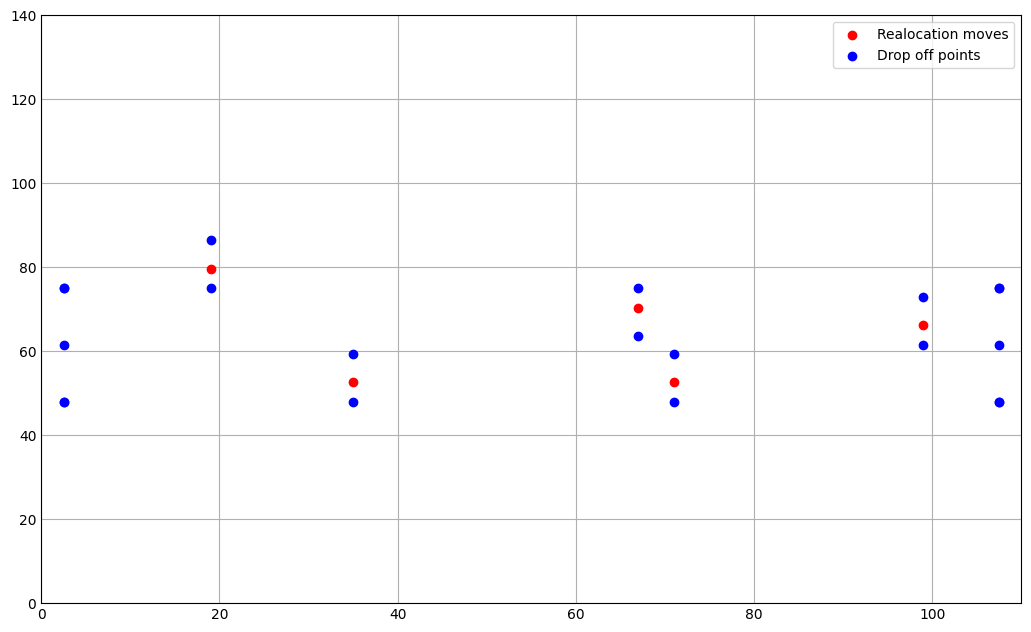

In [42]:
plot_points(D,J,[])


In [43]:
trips=sa_approach(5,4,25,13,126,2500,0.126,J,D)


[1 0]


AttributeError: 'numpy.ndarray' object has no attribute 'append'